# Linear Regression (Part 2)

## Simple Linear Regression (Recap)

A simple linear model relating a single feature, $x$, to an outcome $y$:

$$
y_i = \underbrace{\theta_0}_{\text{y intercept}} + \underbrace{\theta_1}_{\text{slope}} \cdot x_i + \epsilon_i
$$

This is the equation of a line.

### Fitting a linear model

**Goal**
$\theta_0$ and $\theta_1$ are our parameters; they are unknown. We want to find the values of $\theta_0$ and $\theta_1$ that *best fit* our data.

**Goodness of Fit**

 - **Residual** ($\epsilon_i$) - the difference between the actual target value $y_i$ and the model's prediction $\hat{y}_i$, $\epsilon_i = y_i - \hat{y}_i$. We can think of a residual as an error.
 - **Loss function** - For any given data point, we penalize error using a loss function. The most common loss function is squared error, $\epsilon_i^2$.

 - **Cost function** - an aggregation of the loss over a set of data, usually the average of the individual losses. We assess the goodness-of-fit of a model using a **cost function**. The most common cost function is Mean Squared Error (MSE), the average of the squared error of all the data. The lower the cost, the better; lower cost means less error.

 - **Best-fit model** - the choice of $theta$'s that yield the lowest cost over the training or validation data set.

## Linear Regression with Scikit-learn

In the last class, we fit a linear regression from scratch, using only the `numpy` package. Scikit-learn (`sklearn`) is a Python package for machine learning. Let's see how we would fit a model in practice. For this example, I'll again use a synthetic dataset.

### The modeling process

 - Explore data (skip for now)
 - Clean data (skip for now)
 - Engineer features (skip for now)
 - Pre-process data (skip for now)
 - Split data into training and testing sets. Possibly split training sets into training and validation sets.
 - Choose a model type and a choice of hyper-parameters.
 - Fit the model.
 - Assess the model.
 - If you're unsatisfied with the results, go back as many steps as necessary and repeat.


In [1]:
import sklearn as sk

# from sklearn.linear_model import LinearRegression
# from sklearn import train_test_split
# from sklearn.datasets import make_regression

import numpy as np
import matplotlib.pyplot as plt

#### Creating synthetic data

For a simple linear regression, we creat a data set with just one feature and one target.

'True' model:
 y = 32.49 + 44.19 * x


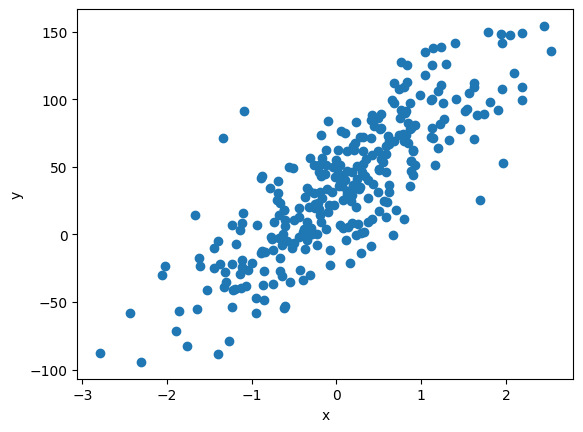

In [2]:

np.random.seed(1)
bias = 20*np.random.randn()

X, y, coef = sk.datasets.make_regression(n_samples=300, 
                                   n_features=1,    # n_features = 1 --> simple linear regression
                                   noise=30, 
                                   bias = bias, 
                                   random_state=1, 
                                   shuffle = False, # samples will be in order
                                   coef = True) 

print(f'\'True\' model:\n y = {bias:.2f} + {coef:.2f} * x')


# plot the data
fig, ax = plt.subplots(1,1)
ax.scatter(X, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


#### Fitting the model

In the cell block below, we do the following steps:

 - Split data into training and testing sets. Typically, we save 20% of the data for training.
 - Choose a model type and a choice of hyper-parameters. We choose [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as the model type, using the default hyper-parameters.
 - Fit the model and calculate MSE and $R^2$ for our training and testing sets.

In [3]:
# Split the data into training and testing sets, it's typical to save 20% of the data for testing
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

# Create and train the model
model_LR = sk.linear_model.LinearRegression()
model_LR.fit(X_train, y_train)

# Make predictions
y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)
y_pred = model_LR.predict(X)

# Assess the model
MSE_train = sk.metrics.mean_squared_error(y_train, y_pred_train)
R2_train = model_LR.score(X_train, y_train)

MSE_test = sk.metrics.mean_squared_error(y_test, y_pred_test)
R2_test = model_LR.score(X_test, y_test)


print(f'model coefficients: {model_LR.coef_[0]}, {model_LR.intercept_}')
print(f'MSE_test = {MSE_test:.2f}, MSE_train = {MSE_train:.2f}')
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')

model_LR.__dict__


model coefficients: 45.244960212447, 33.078033584023714
MSE_test = 580.18, MSE_train = 853.64
R2_test = 0.68, R2_train = 0.69


{'fit_intercept': True,
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([45.24496021]),
 'rank_': 1,
 'singular_': array([14.84030073]),
 'intercept_': np.float64(33.078033584023714)}

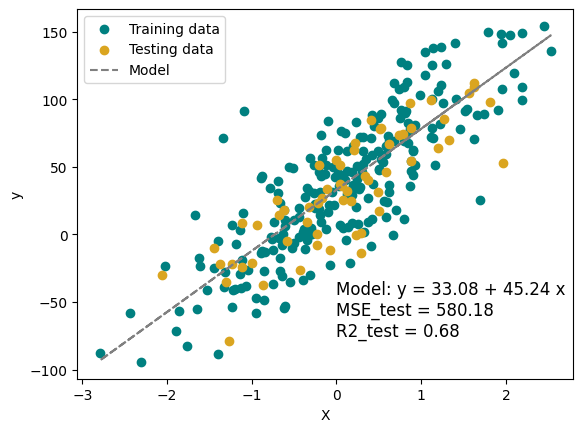

In [4]:
plt.scatter(X_train, y_train, color='teal', label='Training data')
plt.scatter(X_test, y_test, color='goldenrod', label='Testing data')
plt.plot(X, y_pred, color='gray', linestyle = '--', label='Model')

plt.xlabel('X')
plt.ylabel('y')
plt.text(0, -75, f'Model: y = {model_LR.intercept_:.2f} + {model_LR.coef_[0]:.2f} x \nMSE_test = {MSE_test:.2f}\nR2_test = {R2_test:.2f}', fontsize=12)

plt.legend()
plt.show()

### Gradient Descent (Very briefly)

In the last class, we just tried a lot of different values for $\theta_0$ and $\theta_1$ (we tried about 1000 pairs) and picked the values that gave the lowest MSE. This is a brute force method and as our models get even slightly more complex, this method becomes impractical. So how does Scikit-learn fit models?

Recall that when we plot the MSE versus $\theta_0$ and $\theta_1$ we got a bowl shape. The minimum MSE (produced by the best model) is at the bottom of the bowl. Can we find the bottom of the bowl without knowing the entire bowl shape? Yes!


$\underbrace{\Theta_{new}}_{\text{our new guess}} = \underbrace{\Theta_{old}}_{\text{our old guess}} + \underbrace{\gamma}_{\text{learning rate}} \cdot \underbrace{\nabla J(\Theta)}_{\text{gradient of cost}}$

**Gradient descent** - an iterative algorithm for finding a (local) minimum of a function.
 - Start with a guess, any set of parameters $\theta$ for your model.
 - Calculate the gradient of the cost function at that point, say ($\theta_0$, $\theta_1$) for a simple linear regression. The *gradient* is the derivative (slope) of a function at a point. It is a vector, so it has a magnitude (how steep) and direction (where is it sloping).
 - Take a step downhill. The step size is determined by the gradient and learning rate.
 - Keep stepping until $\theta$ has converged, the change from step to step is small.

 **Comments**
  - The *learning rate* contributes to step size. 
    - If learning rate is *too low*, you'll take teeny tiny steps and your model might take a long time to fit. 
    - If learning rate is *too high*, you may step past your minimum.
  - The nice bowl shape is a convenience of linear regression. Not all regressions will have such a simple shape.
  - Some models will create cost landscapes with multiple minima. We want to find the global minimum (the lowest low), but gradient descent finds local minima. Solution, run gradient descent several times using different guesses or use a stochastic gradient descent method.


*Okay that's enough about that.*





## Multiple Linear Regression

In Multiple Linear Regression, we predict the target $y$ using multiple features $x$.

$y = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + \cdots + \theta_n \cdot x_n + \epsilon$

The process is very similar to simple linear regression. Let's make some synthetic data with 2 features and 1 target.

'True' model:
 y = 32.49 + 64.78 * x_1 + 17.98 * x_2


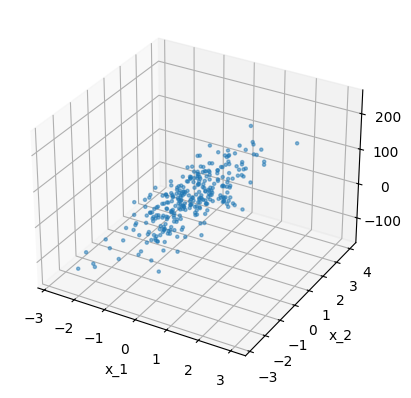

In [5]:
np.random.seed(1)
bias = 20*np.random.randn()

X, y, coef = sk.datasets.make_regression(n_samples=300, 
                                   n_features=2,    # n_features = 1 --> simple linear regression
                                   noise=30, 
                                   bias = bias, 
                                   random_state=1, 
                                   shuffle = False, # samples will be in order
                                   coef = True) 

print(f'\'True\' model:\n y = {bias:.2f} + {coef[0]:.2f} * x_1 + {coef[1]:.2f} * x_2')

# Uncomment the line below for an interactive figure
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:,0], X[:,1], y, s=5, alpha = 0.5)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')

plt.show()

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

# Create and train the model
model_LR = sk.linear_model.LinearRegression()
model_LR.fit(X_train, y_train)

# Make predictions
y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)
y_pred = model_LR.predict(X)

# Assess the model
MSE_train = sk.metrics.mean_squared_error(y_train, y_pred_train)
R2_train = model_LR.score(X_train, y_train)

MSE_test = sk.metrics.mean_squared_error(y_test, y_pred_test)
R2_test = model_LR.score(X_test, y_test)


print(f'model coefficients: {model_LR.coef_}, {model_LR.intercept_}')
print(f'MSE_test = {MSE_test:.2f}, MSE_train = {MSE_train:.2f}')
print(f'R2_test = {R2_test:.2f}, R2_train = {R2_train:.2f}')

model_LR.__dict__

print(f'\nBest-fit Model:\n\ty = {model_LR.intercept_:.2f} + {model_LR.coef_[0]:.2f}*x_1 + {model_LR.coef_[1]:.2f}*x_2')




model coefficients: [63.82273891 20.71147598], 31.82452688535094
MSE_test = 747.16, MSE_train = 872.37
R2_test = 0.78, R2_train = 0.83

Best-fit Model:
	y = 31.82 + 63.82*x_1 + 20.71*x_2


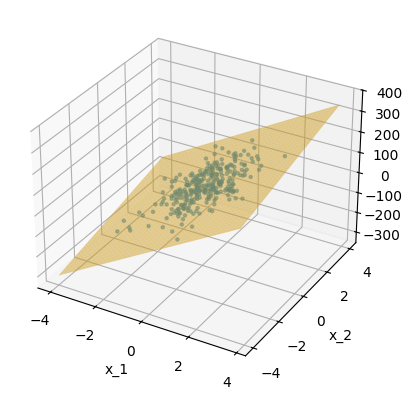

In [7]:
np.random.seed(1)
bias = 20*np.random.randn()

X1, X2 = np.meshgrid(np.arange(-4,4,0.2), np.arange(-4,4,0.2))
X_grid = np.vstack((X1.flatten(), X2.flatten())).transpose()

y_pred_grid = model_LR.predict(X_grid)
y_pred_grid = y_pred_grid.reshape(X1.shape)


from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:,0], X[:,1], y, s=5, alpha = 0.5, label = 'Data')
ax.plot_surface(X1, X2, y_pred_grid, color = 'goldenrod', alpha = 0.5, label = 'Model')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')

plt.show()

### Assumptions

 - *Linearity* - the independent and dependent variables are actually linearly related
 - *Independence* - the observations (samples) are independent of each other
 - *Homoscedasticity* - variance of the errors are uniform across the different values of each independent variable
 - *Normality* - the errors are normal
 - *No collinearity* - the features are not linearly dependent to each other
 
 We will hardly ever encounter data that meets all these assumptions. For some violations, there are workarounds. Others, we acknowledge and accept...or we choose a different type of regression model.
 <br>

 Let's test the Normality assumptions.

(300,)


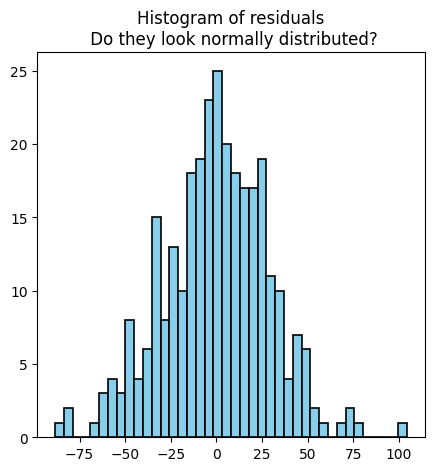

In [8]:
print(y_pred.shape)

residuals = y - y_pred

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.hist(residuals, bins=40, color='skyblue', edgecolor='black', linewidth=1.2)
ax.set_title('Histogram of residuals\n Do they look normally distributed?')
plt.show()



### Selecting features

When we have many features, we may want to select only a subset of features to use. How would we decide which features to use?

*Correlation* between two variables conveys the extent of a linear relationship between the two variables. The *correlation coefficient *, $\rho$, ranges from -1 to 1.
 - $\rho = 1$ is a perfect positive correlation. One variable is exactly linearly related to the other with positive slope.
 - $\rho = -1$ is a perfect negative correlation. One variable is exactly linearly related to the other with negative slope.
 - $\rho = 0$ suggests the two variables are completely uncorrelated.
 - $0 < |\rho| < 1$ suggests some correlation. The two variables might be linearly related, but not exactly due to noisy measurements, non-linearities, unconsidered factors, etc. What is considered good correlation varies from domain to domain.

 We will want to select features that are correlated to the target value but not correlated to eachother (co-linearity). In the next section, we'll see how to automate that selection.
 
 Also...*Correlation does not imply causation!*:

 - Variables may be correlated to the same thing (e.g. ice cream purchases and heat stroke cases are both correlated to temperature).
 - Variables could be correlated by chance. See this site of [Spurious Correlations](https://www.tylervigen.com/spurious-correlations)


**We'll look at this in Problem Set 1!**